In [4]:
import numpy as np
import cv2
import glob

num_x = 9 # 9 corners in x-direction
num_y = 6 # 6 corners in y-direction
size_chessboard=(num_x,num_y)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((num_y*num_x,3), np.float32)
objp[:,:2] = np.mgrid[0:num_x, 0:num_y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

img_size = []

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_size = (img.shape[1], img.shape[0])
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, size_chessboard, None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

In [5]:
# undistort image
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [6]:
def scale_sobel(sobel_in):
    return np.uint8(255*sobel_in/np.max(sobel_in))

# sobel
def combined_thresh(img, sobel_kernel=3, sobel_thresh=(0,255), mag_thresh=(0, 255), dir_thresh=(0, np.pi/2), s_thresh=(0,255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    sobelx= cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely= cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobel_abs_x=np.absolute(sobelx)
    sobel_abs_y=np.absolute(sobely)
    
    scaled_sobel_x = scale_sobel(sobel_abs_x)
    scaled_sobel_y = scale_sobel(sobel_abs_y)

    gradx = np.zeros_like(scaled_sobel_x)
    grady = np.zeros_like(scaled_sobel_y)
    gradx[(scaled_sobel_x >= sobel_thresh[0]) & (scaled_sobel_x <= sobel_thresh[1])] = 1
    grady[(scaled_sobel_y >= sobel_thresh[0]) & (scaled_sobel_y <= sobel_thresh[1])] = 1
    
    #mag thresh
    mag_absSobelxy=np.sqrt(np.square(sobelx)+np.square(sobely))
    scaled_mag_sobel=scale_sobel(mag_absSobelxy)
    
    mag_binary = np.zeros_like(scaled_mag_sobel)
    mag_binary[(scaled_mag_sobel >= mag_thresh[0]) & (scaled_mag_sobel <= mag_thresh[1])] = 1
    
    # dir_thresh
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx)) 
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # combine all four thresholds:
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | 
             ((mag_binary == 1) & (dir_binary == 1) ) | 
             (s_binary == 1) ] = 1
    
    return combined

In [7]:
# perspective transform
def transform(img,src,dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    return warped
    

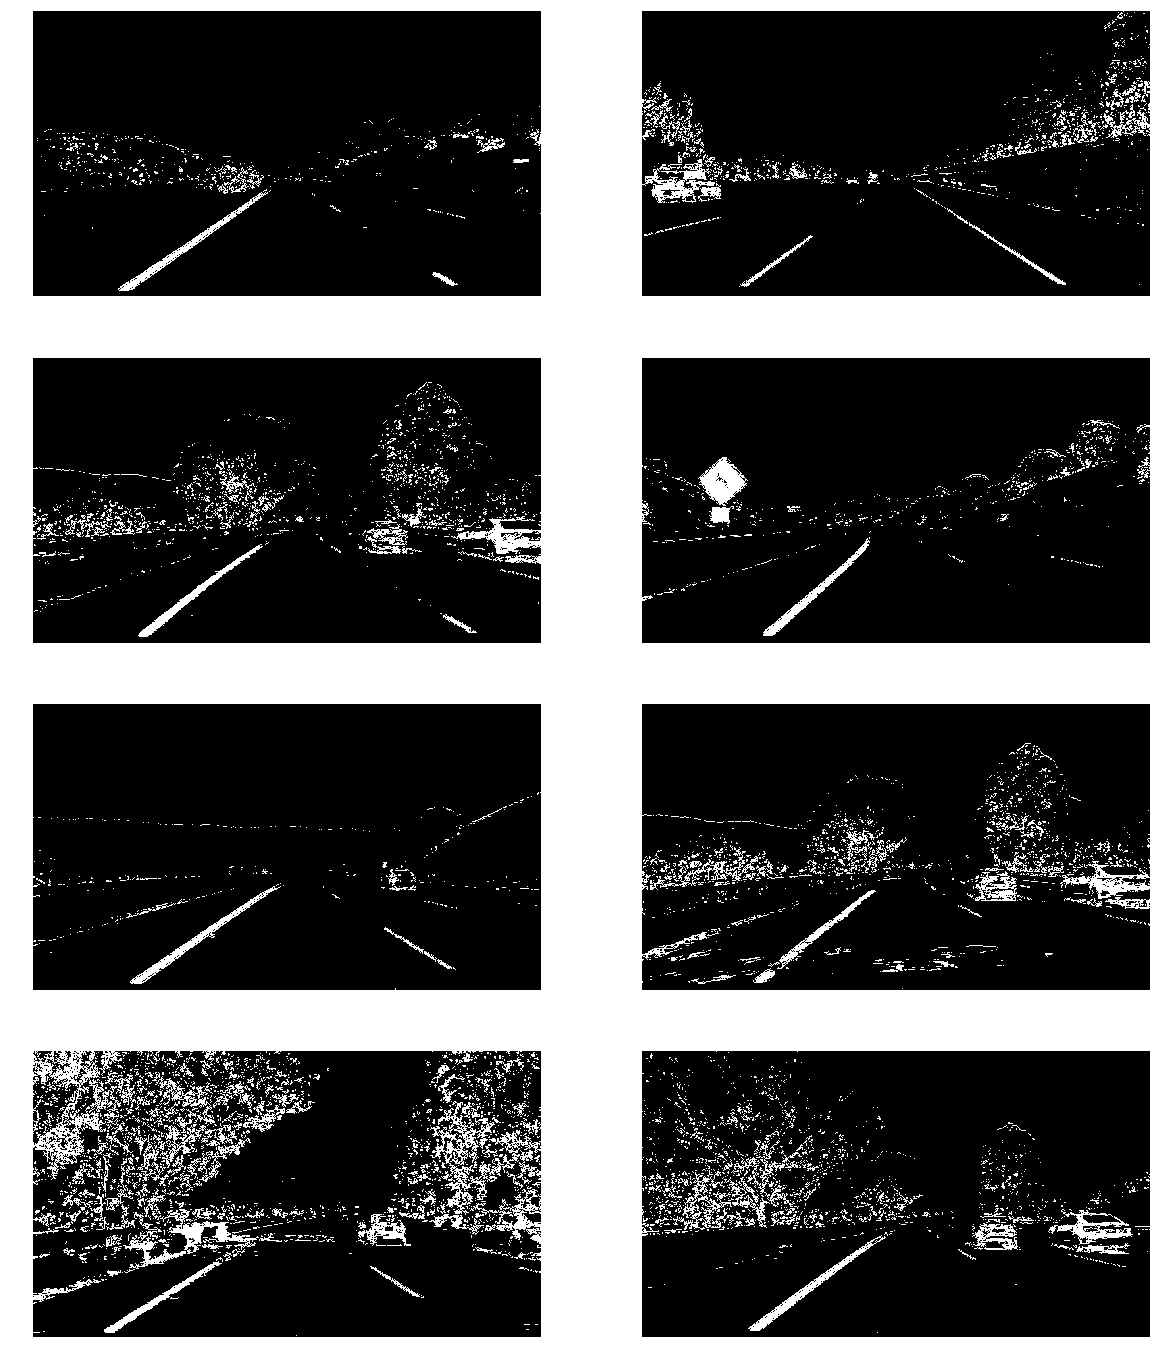

In [8]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

test_images=glob.glob('test_images/*.jpg')
num_images=len(test_images)
plt.figure(figsize=(20,50))
c=1
bitmasks=[]
for fname in test_images:
    test_img = cv2.imread(fname)
    test_img_dist = undistort(test_img)
    out = combined_thresh(test_img_dist,
                          sobel_kernel=3,
                          sobel_thresh=(20,100),
                          mag_thresh=(30,100),
                          dir_thresh=(np.pi/6, np.pi/2),
                          s_thresh=(170,255))
    bitmasks.append(out)
    plt.subplot(num_images,2,c)
    c+=1
    plt.imshow(out,cmap='gray')
    plt.axis('off')

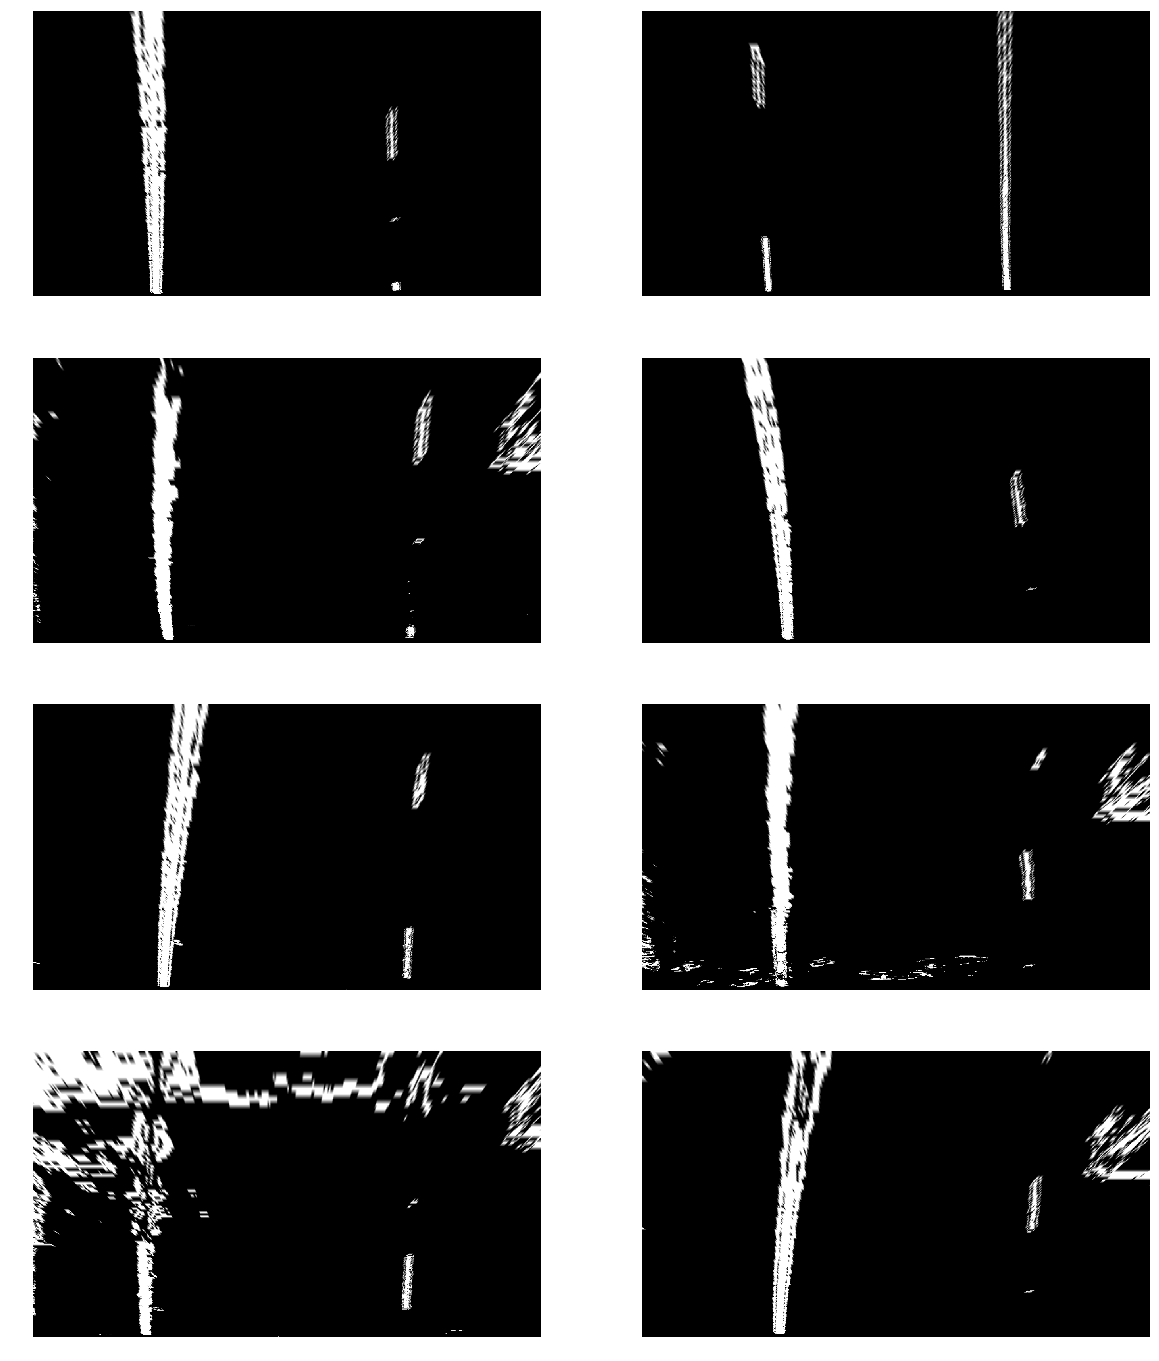

In [9]:
c=1
plt.figure(figsize=(20,50))
src=np.float32([[220,720],[1110,720],[722,470],[570,470]])
dst=np.float32([[320,720],[920,720],[920,1],[300,1]])
bm_transforms=[]
for bm in bitmasks:
    bm_transform= transform(bm,src,dst)
    bm_transforms.append(bm_transform)
    plt.subplot(num_images,2,c)
    c+=1
    plt.imshow(bm_transform,cmap='gray')
    plt.axis('off')

In [10]:
def get_histogram(img):
    histogram=np.sum(img[img.shape[0]//2:,:], axis=0)
    return histogram

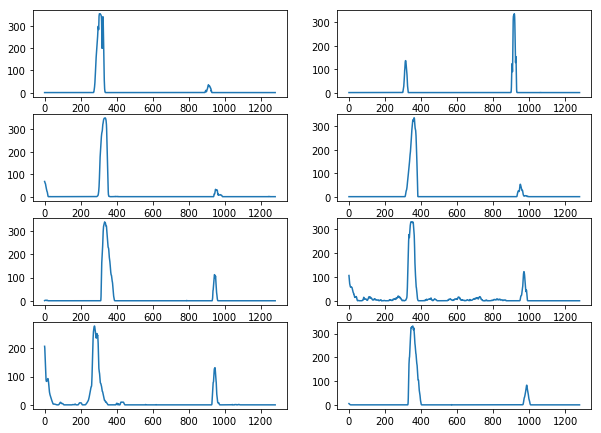

In [11]:
c=1
plt.figure(figsize=(10,15))
histograms=[]
for bm in bm_transforms:
    hst=get_histogram(bm)
    histograms.append(hst)
    plt.subplot(num_images,2,c)
    c+=1
    plt.plot(hst)

In [12]:
def generate_polyline(binary_warped)
    histogram=get_histogram(binary_warped)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

(720, 0)

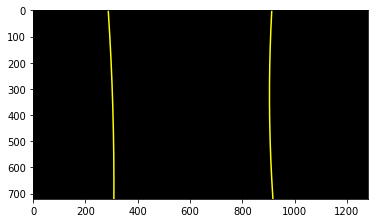

In [13]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)